# BARASA ELIJAH MAIGA
# ACCESS NO:B35499

Data shape: (4898, 39)
Columns: ['gender', 'finalptbcombined', 'temp0', 'hr0', 'rr0', 'spo20', 'clinscore0', 'weight0', 'smoke', 'agesmoke', 'pipesmokerever', 'alcohol', 'marijuanause', 'asthma', 'copd', 'pulmhtn', 'bronchiec', 'pastsickness', 'pastbactpneum', 'psbactp6', 'psbactpinlungs', 'pasttb', 'pastpcp', 'pastcandidiasis', 'pastcrypto', 'diabetesever', 'prhivtest', 'prhivrslt', 'abx0', 'fever0', 'wtloss0', 'cough0', 'homefuel', 'workfumes', 'hiv', 'otherdiagnos', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38']
Class distribution:
 finalptbcombined
0    2954
1    1944
Name: count, dtype: int64
Scaler saved -> scaler.pkl
Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1121     |
|    time_elapsed     | 17       |
|    total_timesteps  | 19592    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.26     |
|    n_updates        | 4872     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1092     |
|    time_elapsed     | 35       |
|    total_timesteps  | 39184    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.77     |
|    n_updates        | 9770     |
----------------------------------
Model saved -> tb_dqn_model.zip


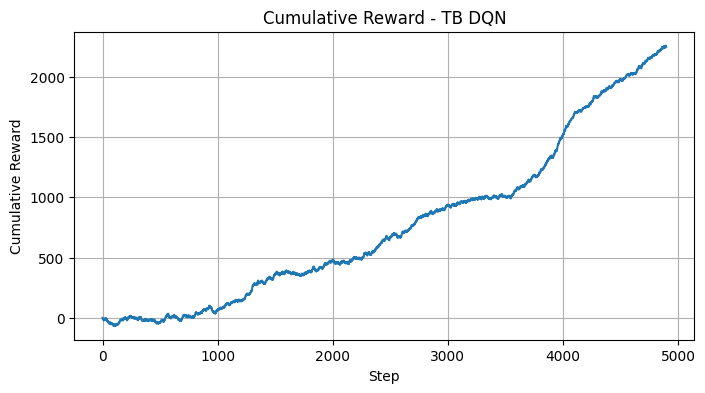

Artifacts ready in Colab working directory:
['.config', 'cumulative_reward.png', 'scaler.pkl', 'tb_dqn_model.zip', 'drive', 'sample_data']

Download tb_dqn_model.zip and scaler.pkl for local deployment.


In [3]:
# ---------------------------
# TB Screening RL - Full Training Script
# ---------------------------
# This script:
# 1) Loads your TB dataset
# 2) Preprocesses features
# 3) Defines a custom Gymnasium environment for TB screening
# 4) Trains a DQN agent using Stable-Baselines3
# 5) Saves the scaler and trained model
# 6) Evaluates cumulative reward
# ---------------------------

# ---------------------------
# 0) Install dependencies (only needed in Colab)
# ---------------------------
!pip install -q stable-baselines3 gymnasium scikit-learn pandas matplotlib joblib

# ---------------------------
# 1) Imports
# ---------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import os

# ---------------------------
# 2) Load dataset (replace with your Colab path)
# ---------------------------
DATA_PATH = "/content/drive/MyDrive/Tb eda presentation/TB_data_full_clean.xlsx"  # <-- change path if needed
df = pd.read_excel(DATA_PATH)

# Preview dataset
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Class distribution:\n", df['finalptbcombined'].value_counts())

# ---------------------------
# 3) Select features & target
# ---------------------------
feature_cols = [
    'gender','temp0','hr0','rr0','spo20',
    'clinscore0','weight0','smoke','agesmoke',
    'fever0','wtloss0','cough0','homefuel',
    'workfumes','hiv','otherdiagnos'
]

# Check missing columns
missing = [c for c in feature_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

X_df = df[feature_cols].fillna(0)  # fill missing values with 0
y = df['finalptbcombined'].astype(int).values

# ---------------------------
# 4) Scale features
# ---------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X_df.values)
joblib.dump(scaler, "scaler.pkl")  # save scaler for later inference
print("Scaler saved -> scaler.pkl")

# ---------------------------
# 5) Define TB Screening Gym Environment
# ---------------------------
class TBScreeningEnv(gym.Env):
    """
    Each step = one patient
    Action 0 = Skip screening
    Action 1 = Screen patient
    Reward designed to produce both 0 and 1 actions
    """
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        self.n = len(X)
        self.index = 0

        # Observation space = scaled feature vector
        self.observation_space = spaces.Box(
            low=-10, high=10, shape=(X.shape[1],), dtype=np.float32
        )

        # Action space = discrete: 0=skip, 1=screen
        self.action_space = spaces.Discrete(2)

    def reset(self, seed=None):
        self.index = 0
        return self.X[self.index], {}  # return first observation

    def step(self, action):
        tb = int(self.y[self.index])

        # ---------------------------
        # Reward shaping for both 0 and 1 actions:
        # - screen & TB -> +5
        # - screen & not TB -> -1
        # - skip & TB -> -5
        # - skip & not TB -> +2
        # ---------------------------
        if action == 1:
            reward = 5 if tb == 1 else -1
        else:
            reward = -5 if tb == 1 else 2

        self.index += 1
        done = self.index >= self.n
        obs = self.X[self.index-1] if not done else np.zeros(self.X.shape[1], dtype=np.float32)
        return obs, float(reward), done, False, {}

# Wrap environment for Stable-Baselines3
env = DummyVecEnv([lambda: TBScreeningEnv(X, y)])

# ---------------------------
# 6) Train DQN Agent
# ---------------------------
model = DQN(
    "MlpPolicy",          # Neural network policy
    env,                  # Gym environment
    learning_rate=1e-3,   # LR
    buffer_size=10000,    # Replay buffer
    exploration_fraction=0.2,  # Exploration decay
    verbose=1
)

TOTAL_TIMESTEPS = 50000  # Increase if needed for convergence
model.learn(total_timesteps=TOTAL_TIMESTEPS)

# Save model
MODEL_PATH = "tb_dqn_model"
model.save(MODEL_PATH)
print("Model saved ->", MODEL_PATH + ".zip")

# ---------------------------
# 7) Quick evaluation (cumulative reward curve)
# ---------------------------
rewards = []
for i in range(len(X)):
    obs = X[i]
    action, _ = model.predict(obs, deterministic=True)
    tb = y[i]
    if action == 1:
        r = 5 if tb==1 else -1
    else:
        r = -5 if tb==1 else 2
    rewards.append(r)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(rewards))
plt.title("Cumulative Reward - TB DQN")
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.savefig("cumulative_reward.png", dpi=150)
plt.show()

# ---------------------------
# 8) Artifacts ready
# ---------------------------
print("Artifacts ready in Colab working directory:")
print(os.listdir('.'))
print("\nDownload tb_dqn_model.zip and scaler.pkl for local deployment.")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
